# REGRESIÓN LOGÍSTICA
## Sobre un conjunto No Separable Linealmente
### Medidas de evaluación

Por Alejandro Ramos @arhcoder

In [211]:
# Librerías necesarias:
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [212]:
# Obtención de los datos:
df = pd.read_csv("/content/data-ejercicio1.txt")
df.columns = ['x1', 'x2', 'target']
print(df)

           x1        x2  target
0   -0.092742  0.684940       1
1   -0.213710  0.692250       1
2   -0.375000  0.502190       1
3   -0.513250  0.465640       1
4   -0.524770  0.209800       1
..        ...       ...     ...
112 -0.720620  0.538740       0
113 -0.593890  0.494880       0
114 -0.484450  0.999270       0
115 -0.006336  0.999270       0
116  0.632650 -0.030612       0

[117 rows x 3 columns]


<Axes: xlabel='x1', ylabel='x2'>

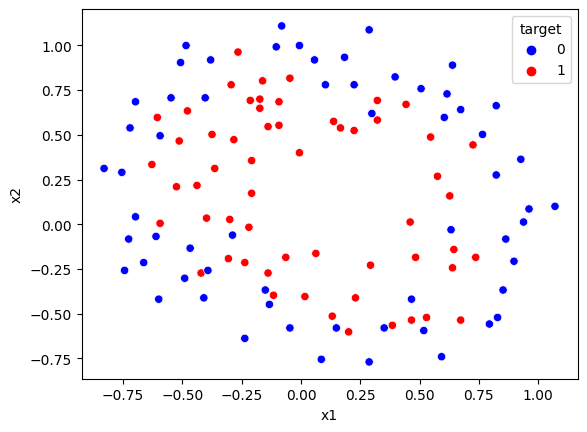

In [213]:
# Graficación de los datos:
sns.scatterplot(x='x1', y='x2', hue='target', data=df, palette={0: "blue", 1: "red"})

Se comprueba mediante el gráfico anterior que no hay manera lineal de separar los datos, por ello se prueba mediante distintos grados para el ajuste de los datos...

# Escalamiento de los datos

<Axes: xlabel='x1', ylabel='x2'>

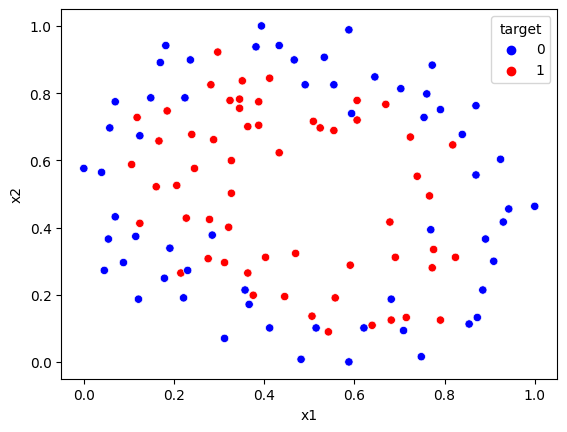

In [214]:
scaler = MinMaxScaler()
df[["x1", "x2"]] = scaler.fit_transform(df[["x1", "x2"]])
sns.scatterplot(x='x1', y='x2', hue='target', data=df, palette={0: "blue", 1: "red"})

No parece haber diferencia con el escalado...

**Pero primero se implementan las funciones para la Regresión...**

# REGRESIÓN LOGÍSTICA

In [215]:
# Función Softmax:
def softmax(x, classes):

  # Datos de longitud:
  data_length, attributes = x.shape
  probabilities = np.random.rand(data_length, classes)

  # Para el máximo de cada fila de x:
  for i in range(data_length):
    max = np.max(x[i])
    sum = 0

    for j in range(classes):
      sum += np.exp(x[i, j] - max)

    for j in range(classes):
      probabilities[i, j] = np.exp(x[i, j] - max) / sum

  return probabilities

In [216]:
# Función de costo:
def cross_entropy(y_prediction, y_real):

  # Datos de longitud:
  data_length = y_prediction.shape[0]
  classes = len(np.unique(y_real))
  cost = 0

  # Sumatoria:
  for i in range(data_length):
    for j in range(classes):
      if j == y_real[j]:
        cost -= np.log(y_prediction[i, j])

  return cost / data_length

In [217]:
# Función de ajuste del modelo:
def fit(X, y, learning_rate, iterations):

  # Datos de longitud:
  data_length, attributes = X.shape
  classes = len(np.unique(y))

  # Se inicializan la matriz de pesos y los sesgos:
  W = np.random.rand(attributes, classes)
  b = np.random.rand(1, classes)

  # Se realizan iteraciones para el descenso del gradiente:
  for _ in range(iterations):

    # Valores lineales de preactivación:
    pre_activation = X @ W + b

    # Probabilidades dadas por la función softmax:
    probabilities = softmax(pre_activation, classes)

    # Función de costo con las probabilidades:
    error = cross_entropy(probabilities, y)

    # Se calcula el gradiente:
    gradient = probabilities
    gradient[range(data_length), y] -= 1
    gradient /= data_length

    # Se actualizan los valores de W y b según el descenso del gradiente:
    W -= learning_rate * X.T @ gradient
    b -= learning_rate * np.sum(gradient, axis=0).reshape(1, -1)

  # Retorna los pesos ajustados "W", el sesgo "b" y el error del ajuste:
  return W, b, error

In [218]:
# Función para medir el accuracy del modelo:
def predict(X, y, W, b):

  # Valores lineales de preactivación:
  pre_activation = X @ W + b

  # Probabilidades dadas por la función softmax:
  classes = len(np.unique(y))
  probabilities = softmax(pre_activation, classes)
  y_prediction = np.argmax(probabilities, axis=1)
  accuracy = np.mean(y_prediction == y)
  return accuracy

# Métricas de evaluación

In [219]:
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score

# Función para calcular la matriz de confusión:
def calculate_confusion_matrix(y_pred, y_true):
    cm = confusion_matrix(y_pred, y_true)
    return cm

# Función para calcular el F1-score:
def calculate_f1_score(y_pred, y_true):
    f1 = f1_score(y_pred, y_true, average="weighted")
    return f1

# Función para calcular el AUC:
def calculate_auc(y_true, y_prob):
    num_classes = y_prob.shape[1]
    aucs = []

    for i in range(num_classes):
        positive_class = i
        y_true_binary = (y_true == positive_class).astype(int)
        auc = roc_auc_score(y_true_binary, y_prob[:, i])
        aucs.append(auc)

    mean_auc = np.mean(aucs)
    return mean_auc

# Implementación de la regresión

In [220]:
# Grados para probar:
grades = [2, 3, 4, 5, 6, 7, 8]
scores = list()

# Se prueba transformar el data ser para distintos grados:
for grade in grades:

  # Agrega una columna con el nuevo grado:
  df[f"x1_g{grade}"] = df["x1"] ** grade
  df[f"x2_g{grade}"] = df["x2"] ** grade

  # División de conjunto de entrenamiento y pruebas:
  df_shuffle = df.sample(frac=1, random_state=0)
  df_train = df_shuffle.sample(frac = 0.8)
  df_test = df_shuffle.drop(df_train.index)

  # Toma todas las transformaciones excepto "target":
  X_train = df_train.loc[:, df_train.columns != "target"].to_numpy()
  y_train = df_train[["target"]].to_numpy()

  # Entrena el modelo:
  W, b, e = fit(X_train, y_train, 0.1, 1000)

  # Realiza predicciones:
  X_test = df_test.loc[:, df_train.columns != "target"].to_numpy()
  y_test = df_test[["target"]].to_numpy()
  accuracy = predict(X_test, y_test, W, b)

  # Métricas de evaluación:
  # Calcula las predicciones finales:
  final_pre_activation = X_test @ W + b
  final_probabilities = softmax(final_pre_activation, 2)
  y_pred = np.argmax(final_probabilities, axis=1)
  y_prob = softmax(X_test @ W + b, 2)

  # Obtiene las métricas:
  confusion_mat = calculate_confusion_matrix(y_test, y_pred)
  f1 = calculate_f1_score(y_test, y_pred)
  auc = calculate_auc(y_test, y_prob)

  # Guarda los resultados en listas:
  scores.append({"Grade": grade, "Accuracy": accuracy, "ConfMatrix": confusion_mat, "F1": f1, "AUC": auc})
  print(f"Grade {grade} terminated!")

Grade 2 terminated!
Grade 3 terminated!
Grade 4 terminated!
Grade 5 terminated!
Grade 6 terminated!
Grade 7 terminated!
Grade 8 terminated!


In [224]:
# Resutados:
for score in scores:
  print("\n_______________________")
  print(f"\nGrade {score['Grade'] }:")
  print(f" * Accuracy: {score['Accuracy'] * 100:.4f}%")
  print(f" * F1-Score: {score['F1'] * 100:.4f}%")
  print(f" * AUC: {score['AUC'] * 100:.4f}%")
  print(f" * Consufion Matrix:\n{score['ConfMatrix']}")
print("\n_______________________")


_______________________

Grade 2:
 * Accuracy: 50.0945%
 * F1-Score: 65.2174%
 * AUC: 53.7879%
 * Consufion Matrix:
[[7 4]
 [4 8]]

_______________________

Grade 3:
 * Accuracy: 51.9849%
 * F1-Score: 64.5273%
 * AUC: 78.4615%
 * Consufion Matrix:
[[10  3]
 [ 5  5]]

_______________________

Grade 4:
 * Accuracy: 50.6616%
 * F1-Score: 59.9542%
 * AUC: 62.1212%
 * Consufion Matrix:
[[5 6]
 [3 9]]

_______________________

Grade 5:
 * Accuracy: 49.5274%
 * F1-Score: 69.2174%
 * AUC: 72.7273%
 * Consufion Matrix:
[[7 5]
 [2 9]]

_______________________

Grade 6:
 * Accuracy: 50.4726%
 * F1-Score: 57.0234%
 * AUC: 55.5556%
 * Consufion Matrix:
[[8 6]
 [4 5]]

_______________________

Grade 7:
 * Accuracy: 48.5822%
 * F1-Score: 38.6693%
 * AUC: 36.1538%
 * Consufion Matrix:
[[4 9]
 [5 5]]

_______________________

Grade 8:
 * Accuracy: 51.4178%
 * F1-Score: 26.6633%
 * AUC: 19.0476%
 * Consufion Matrix:
[[1 8]
 [9 5]]

_______________________


# Graficación de resultados

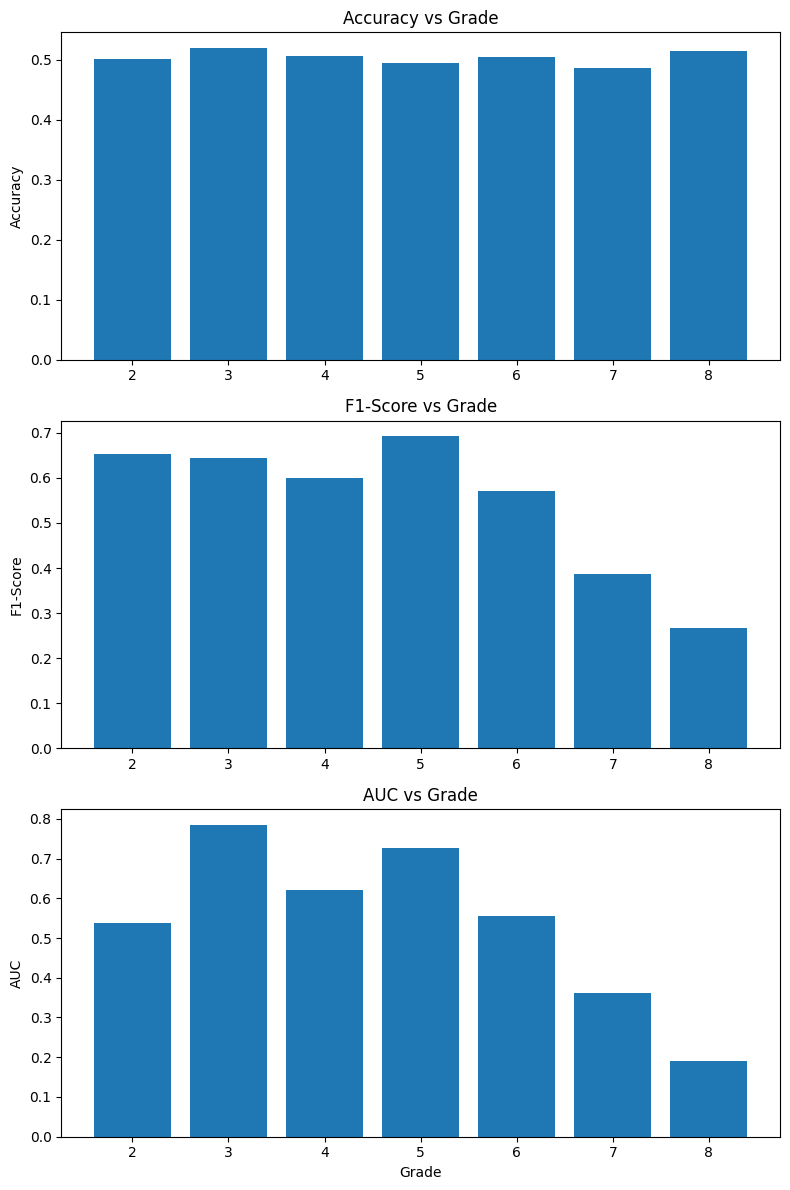

In [226]:
# Extrae las métricas:
grades = [score["Grade"] for score in scores]
accuracy = [score["Accuracy"] for score in scores]
f1_score = [score["F1"] for score in scores]
auc = [score["AUC"] for score in scores]

# Crea subplots para Accuracy, F1-Score y AUC:
fig, axes = plt.subplots(3, 1, figsize=(8, 12))

# Gráfico de barras para el Accuracy:
axes[0].bar(grades, accuracy)
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Accuracy vs Grade")

# Gráfico de barras para F1-Score:
axes[1].bar(grades, f1_score)
axes[1].set_ylabel("F1-Score")
axes[1].set_title("F1-Score vs Grade")

# Gráfico de barras para AUC:
axes[2].bar(grades, auc)
axes[2].set_xlabel("Grade")
axes[2].set_ylabel("AUC")
axes[2].set_title("AUC vs Grade")

plt.tight_layout()
plt.show()